# 📊 Inventory Demand Forecasting



# Step 1: Importing Libraries and Dataset


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

# Step 2: Load and Explore the Dataset


In [5]:
df = pd.read_csv('StoreDemand.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [6]:
df.shape

(913000, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


# Step 3: Feature Engineering


In [9]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [15]:
from datetime import datetime

# split date into year, month, day
parts = df["date"].str.split("-", n=3, expand=True)
df["year"] = parts[0].astype(int)
df["month"] = parts[1].astype(int)
df["day"] = parts[2].astype(int)

# function to check if weekend (Sat=5, Sun=6)
def weekend_or_weekday(year, month, day):
    d = datetime(year, month, day)
    return 1 if d.weekday() > 4 else 0   # 1 = weekend, 0 = weekday

# apply function to create new column
df["weekend"] = df.apply(lambda x: weekend_or_weekday(x["year"], x["month"], x["day"]), axis=1)

# show sample with new columns
df[["date", "year", "month", "day", "weekend"]].head()


,date,year,month,day,weekend
0,2013-01-01,2013,1,1,0
1,2013-01-02,2013,1,2,0
2,2013-01-03,2013,1,3,0
3,2013-01-04,2013,1,4,0
4,2013-01-05,2013,1,5,1


In [18]:
from datetime import date
import holidays

# Get Indian holidays
india_holidays = holidays.country_holidays('IN')

# Create holiday column (1 if holiday, else 0)
df['holidays'] = df['date'].apply(lambda x: 1 if india_holidays.get(x) else 0)

# Show preview exactly like original
df[['date', 'store', 'item', 'sales', 'year', 'month', 'day', 'weekend', 'holidays']].head()


,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


In [19]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


In [21]:
from datetime import datetime

def which_day(year, month, day):
    return datetime(year, month, day).weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'], x['month'], x['day']), axis=1)
df[['date','store','item','sales','year','month','day','weekend','holidays','m1','m2','weekday']].head()


,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5


In [22]:
df.drop('date', axis=1, inplace=True)

# Step 4: Exploratory Data Analysis


In [23]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

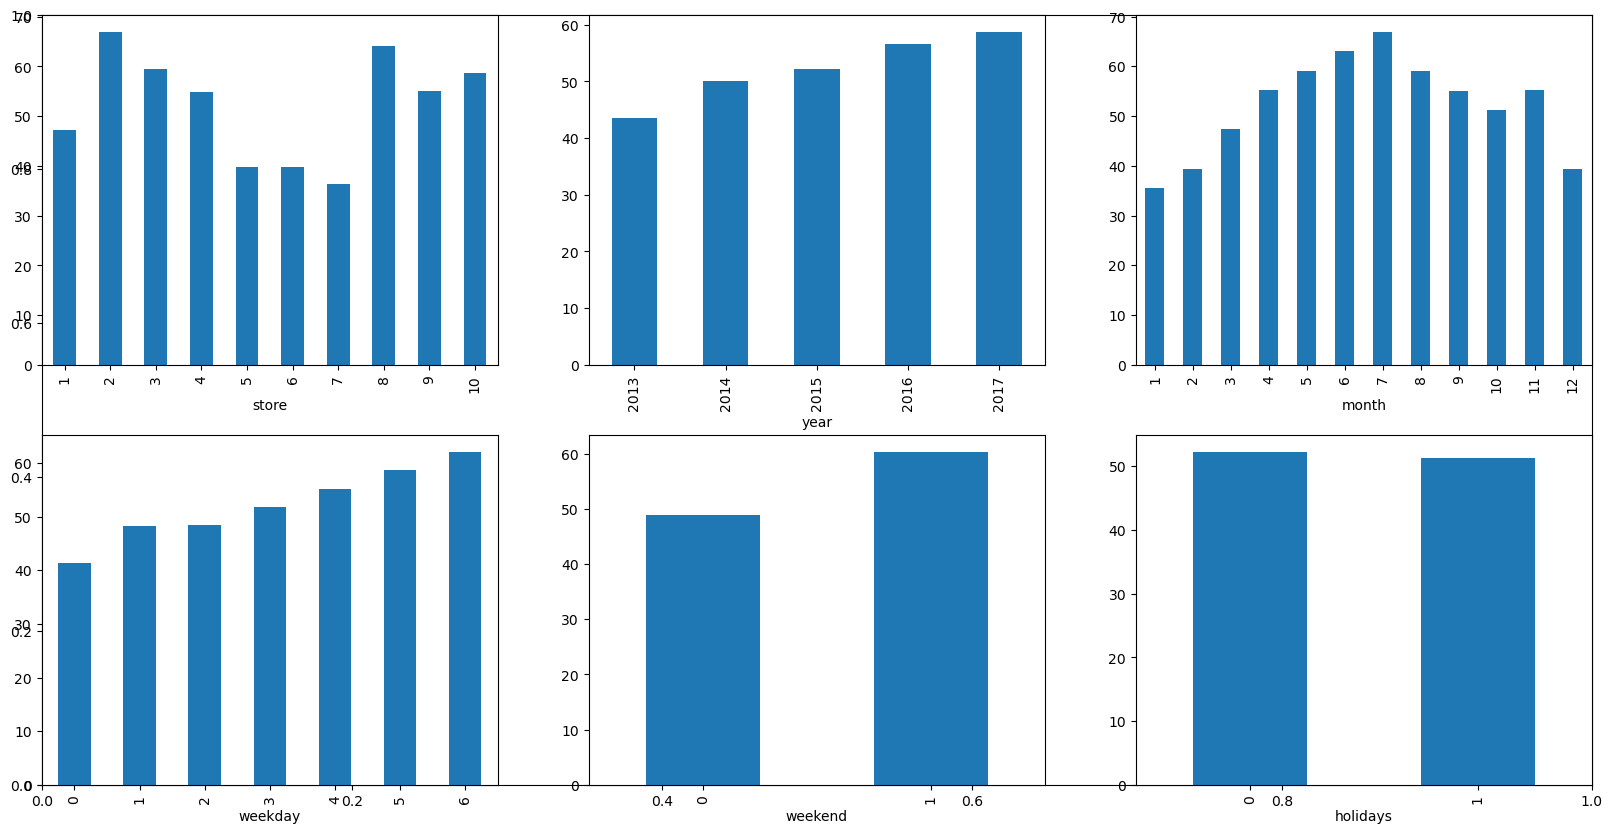

In [24]:
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

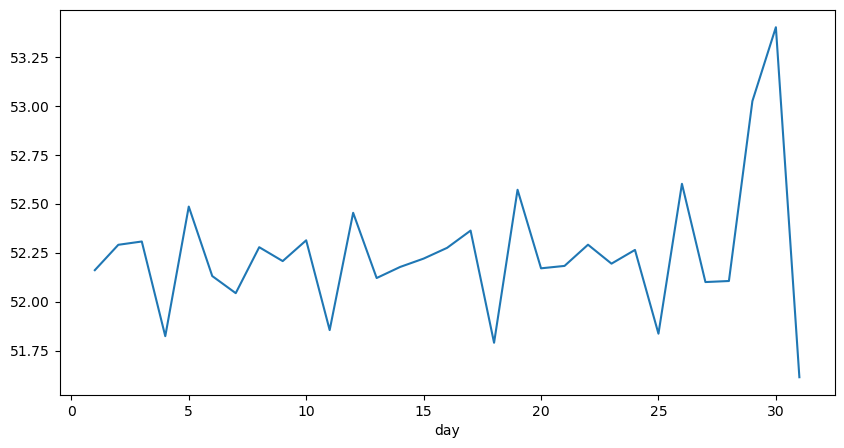

In [25]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

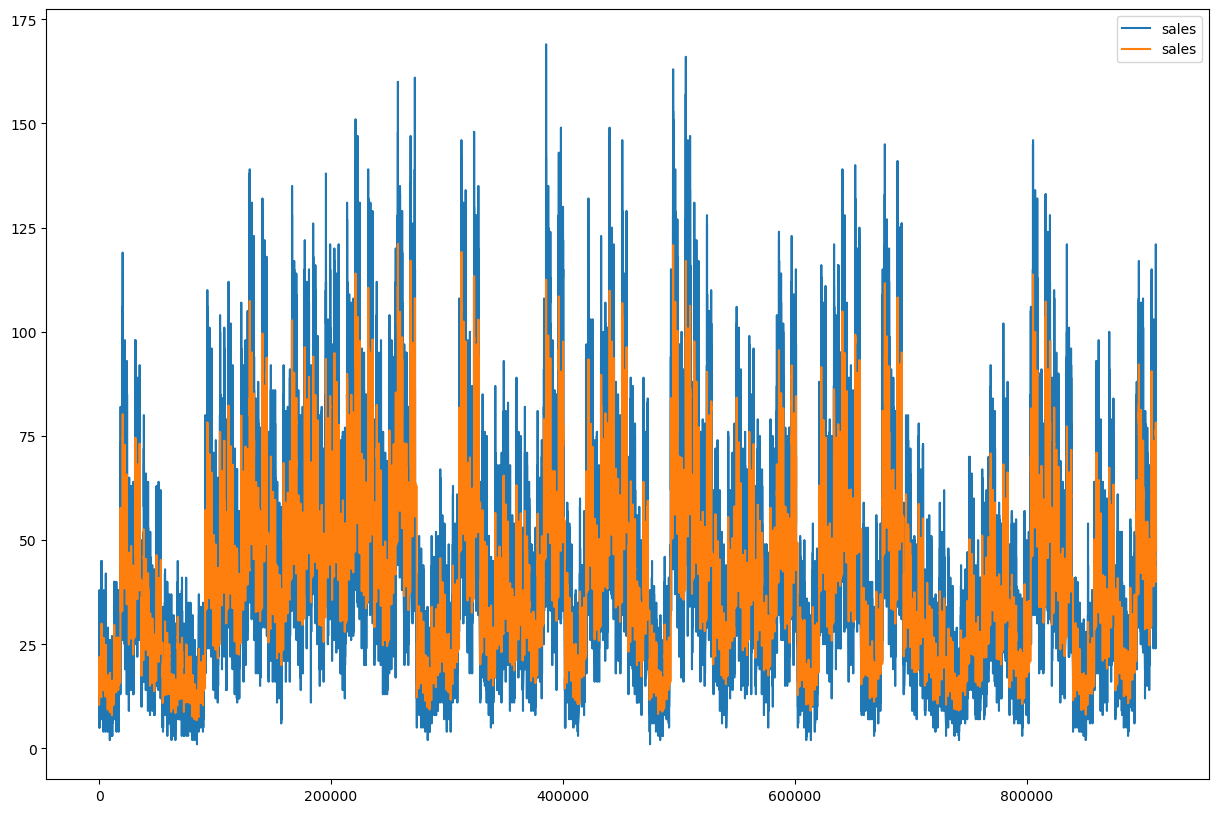

In [26]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average 
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

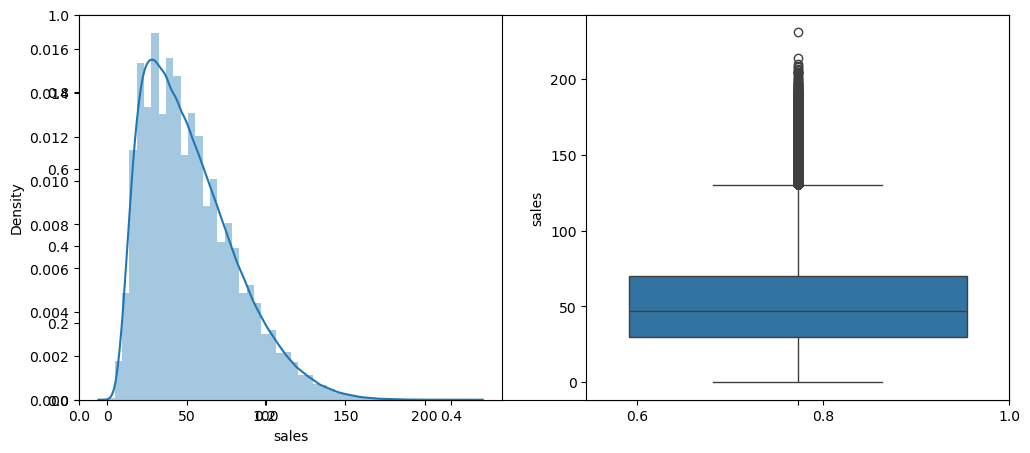

In [27]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

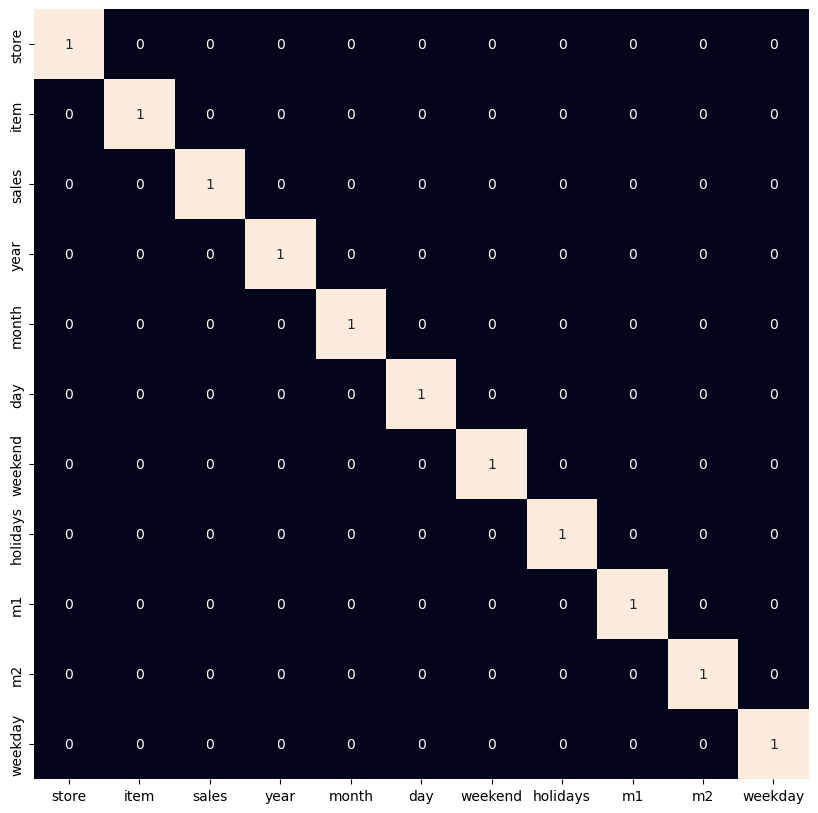

In [28]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [29]:
df = df[df['sales']<140]

# Step 5: Model Training


In [30]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size = 0.05,
                                                  random_state=22)
X_train.shape, X_val.shape

((861170, 9), (45325, 9))

In [31]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [32]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  20.903011639935794
Validation Error :  20.971878842602617

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) : 
Training Error :  6.9172892570495605
Validation Error :  6.9274091720581055

Lasso() : 
Training Error :  21.015028699769758
Validation Error :  21.